

# How To Use Stackix
Stackix is our implementation of a stacked/hierachial autoencoder.  
This tutorial follows the structure of our `Getting Started - Vanillix`, but is much less extenisve, because
our pipeline works similar for different architecture, so here we focus only on Stackix specifics.

**AUTOENCODIX** supports far more functionality than shown here, so we’ll also point to advanced tutorials where relevant.  

**IMPORTANT**

> This tutorial only shows the specifics of the Stackix pipeline. If you're unfamilar with general concepts,  
> we recommend to follow the `Getting Started - Vanillix` Tutorial first.

## Stackix Theory

In our implementation, we train one variational autoencoder (VAE) per data modality end-to-end. The latent spaces of these *outer* autoencoders are then concatenated and used as input to another *inner* autoencoder. We perform downstream visualization and evaluation on this **meta-latent space**.  

For unpaired data, each outer autoencoder is trained on all available samples of its modality, even if the corresponding sample is missing in the other modalities. When constructing the input for the inner autoencoder, we drop non-overlapping samples to ensure consistency across modalities.  

This approach has two goals:  
1. To produce more informative latent spaces for each modality.  
2. To provide a richer, joint representation for the inner autoencoder.  

We also store the dropped samples and their indices. This allows us to reconstruct the full dataset: the output of the inner autoencoder can be passed back through the outer autoencoders, where decoding recovers the original modalities.  


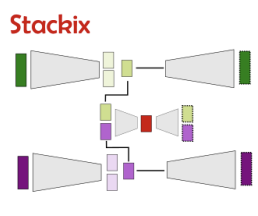. . 

---
## What You'll Learn

You’ll learn how to:

1. **Initialize** the pipeline and run the pipeline. <br> <br>
2. Understand the Stackix sepecific **pipeline steps** (paired vs. unpaired data). <br><br>
3. Access the Stackix specific **results** (sub-results for "outer" autoencoders). <br><br>
4. **Visualize** outputs. <br><br>
5. Apply **custom parameters**. <br><br>
6. **Save, load, and reuse** a trained pipeline. <br><br>

---

Let’s get started! 🚀

## 1) Initialize and Run Stackix
We set a few custom parameters of the config file. For a deep dive into the config object see: 

`Tutorials/DeepDives/ConfigTutorial.ipynb`

In [1]:
import autoencodix as acx
from autoencodix.configs.default_config import DataCase
from autoencodix.configs.stackix_config import StackixConfig
from autoencodix.utils.example_data import EXAMPLE_MULTI_BULK

# Stackix has its own config class
# instead of passing a pandas DataFrame, we use a pre-defined DataPackage object directly.
# this time with single cell data
print("Input data:")
print(EXAMPLE_MULTI_BULK)
print("-" * 50)
my_config = StackixConfig(
    epochs=27,
    checkpoint_interval=5,
    default_vae_loss="kl",  # kl or mmd possible
    data_case=DataCase.MULTI_BULK,
)
print("\n")
print("Starting Pipeline")
print("-" * 50)
print("-" * 50)
stackix = acx.Stackix(data=EXAMPLE_MULTI_BULK, config=my_config)
result = stackix.run()

Input data:
multi_bulk:
  transcriptomics: 500 samples × 100 features
  proteomics: 500 samples × 80 features
annotation:
  transcriptomics: 500 samples × 3 features
  proteomics: 500 samples × 3 features
--------------------------------------------------


Starting Pipeline
--------------------------------------------------
--------------------------------------------------
in handle_direct_user_data with data: <class 'autoencodix.data.datapackage.DataPackage'>
anno key: transcriptomics
anno key: proteomics
Training each modality model...
Training modality: transcriptomics
Training modality: transcriptomics
Epoch 1 - Train Loss: 15.7120
Sub-losses: recon_loss: 15.7120, var_loss: 0.0000, anneal_factor: 0.0000, effective_beta_factor: 0.0000
Epoch 1 - Valid Loss: 12.0904
Sub-losses: recon_loss: 12.0904, var_loss: 0.0000, anneal_factor: 0.0000, effective_beta_factor: 0.0000
Epoch 2 - Train Loss: 14.5999
Sub-losses: recon_loss: 14.5999, var_loss: 0.0000, anneal_factor: 0.0001, effective_be

## 2) Stackix Specific Steps

Stackix does not introduce additional steps to the overall pipeline. However, its preprocessing and training differ slightly from Varix and Vanillix. Stackix processes each data modality individually and thus supports unpaired data input.   

This is enabled by setting the config parameter `requires_paired=False`.
In the following example we build unpaired data by dropping samples from our `raw_rna` sample data. The outer autoencoder for the protein data modality will still train with those dropped samples ("sample_2", "sample_8", ...). These sample will only be dropped, when concating the latentspaces for the inner autoencoder. We can later add these samples to the output of the inner autoencoder and feed into the decoder of the outer protein autoencoder, thus allowing a full recosntruction.


In [2]:
import pandas as pd

from autoencodix.data.datapackage import DataPackage
from autoencodix.utils.example_data import annotation, raw_protein, raw_rna
from autoencodix.configs.stackix_config import StackixConfig
from autoencodix.configs.default_config import DataCase
import autoencodix as acx

rna_anno: pd.DataFrame = annotation.drop(
    index=["sample_2", "sample_8", "sample_50", "sample_61"]
)
print(rna_anno.shape)
rna_unpaired: pd.DataFrame = raw_rna.drop(
    index=["sample_2", "sample_8", "sample_50", "sample_61"]
)
print(rna_unpaired.shape)
unpaired_dp: DataPackage = DataPackage(
    multi_bulk={"rna": rna_unpaired, "protein": raw_protein},
    annotation={"rna": rna_anno, "protein": annotation},
)
unpaired_config: StackixConfig = StackixConfig(
    data_case=DataCase.MULTI_BULK, requires_paired=False
)
unpaired_stackix: acx.Stackix = acx.Stackix(data=unpaired_dp, config=unpaired_config)
unpaired_result = unpaired_stackix.run()

(496, 3)
(496, 100)
in handle_direct_user_data with data: <class 'autoencodix.data.datapackage.DataPackage'>
anno key: rna
anno key: protein
Training each modality model...
Training modality: rna
Training modality: rna
Epoch 1 - Train Loss: 14.9434
Sub-losses: recon_loss: 14.9434, var_loss: 0.0000, anneal_factor: 0.0000, effective_beta_factor: 0.0000
Epoch 1 - Valid Loss: 13.4641
Sub-losses: recon_loss: 13.4641, var_loss: 0.0000, anneal_factor: 0.0000, effective_beta_factor: 0.0000
Epoch 2 - Train Loss: 13.7622
Sub-losses: recon_loss: 13.7473, var_loss: 0.0148, anneal_factor: 0.0344, effective_beta_factor: 0.0034
Epoch 2 - Valid Loss: 13.1634
Sub-losses: recon_loss: 13.1555, var_loss: 0.0080, anneal_factor: 0.0344, effective_beta_factor: 0.0034
Epoch 3 - Train Loss: 13.1500
Sub-losses: recon_loss: 12.7652, var_loss: 0.3848, anneal_factor: 0.9656, effective_beta_factor: 0.0966
Epoch 3 - Valid Loss: 13.3140
Sub-losses: recon_loss: 13.0234, var_loss: 0.2906, anneal_factor: 0.9656, effecti

## 3) Access Stackix Specific Outputs
As explained above, we train outer autoencoders for each data modality and one shared inner autoencoder.  
The results (losses, reconstructions, latentspaces, etc) for the inner autoencoder can be accessed as for the Vanillix Autencoder (see [1] and [2]). The results for the outer autoencoders are stored in a special sub-result structure as explained in the Python code below.  

The `sub_results` can be accessed as attribute of the `result` object. On the first level this is a `Dict` with the data modality keys (as defined in step 1). The value is then a `result` object analog to the general result object. This can be accessed via our standard API see also [2].

[1] `Tutorials/PipelineTutorials/Vanillix.ipynb`
[2] `Tutorials/DeepDives/PipelineOutputTutorial.ipynb `


In [3]:
outer_result = result.sub_results
print(outer_result.keys())

dict_keys(['transcriptomics', 'proteomics'])


In [4]:
print(outer_result["proteomics"])
# access latentspace of outer proteomics autoencoder
outer_result["proteomics"].latentspaces.get(split="test", epoch=-1)

Result Object Public Attributes:
------------------------------
latentspaces: TrainingDynamics object
sample_ids: TrainingDynamics object
reconstructions: TrainingDynamics object
mus: TrainingDynamics object
sigmas: TrainingDynamics object
losses: TrainingDynamics object
sub_losses: LossRegistry(_losses={'recon_loss': TrainingDynamics(), 'var_loss': TrainingDynamics(), 'anneal_factor': TrainingDynamics(), 'effective_beta_factor': TrainingDynamics()})
preprocessed_data: Tensor of shape (0,)
model: VarixArchitecture
model_checkpoints: TrainingDynamics object
datasets: DatasetContainer(train=None, valid=None, test=None)
new_datasets: DatasetContainer(train=None, valid=None, test=None)
adata_latent: AnnData object with n_obs × n_vars = 0 × 0
final_reconstruction: None
sub_results: None
sub_reconstructions: None
embedding_evaluation: Empty DataFrame
Columns: []
Index: []


array([[-0.26699403,  1.425206  ,  1.2672164 , ...,  1.0097464 ,
         0.87286735,  1.1162832 ],
       [-0.43193546, -1.1828773 , -0.7503553 , ...,  0.7920977 ,
        -0.8546357 ,  0.9997294 ],
       [ 1.5198641 ,  2.260607  ,  0.486983  , ..., -0.221118  ,
         0.35869798, -0.27126238],
       ...,
       [ 0.41988802, -0.5834491 , -0.37387994, ..., -0.69466066,
         0.35913056,  0.27877992],
       [-0.9548112 , -2.4504712 , -0.889151  , ...,  2.331549  ,
        -0.9817169 ,  1.9549085 ],
       [ 0.01169859, -1.0133258 ,  1.4632468 , ...,  1.2104638 ,
         0.71442264,  0.18339813]], shape=(100, 16), dtype=float32)

In [5]:
# the inner result can be accessed directly
result.latentspaces.get(split="test", epoch=-1)
# or as dataframe with ids
result.get_latent_df(split="test", epoch=-1)

,LatDim_0,LatDim_1,LatDim_2,LatDim_3,LatDim_4,LatDim_5,LatDim_6,LatDim_7,LatDim_8,LatDim_9,LatDim_10,LatDim_11,LatDim_12,LatDim_13,LatDim_14,LatDim_15
sample_0,0.666342,0.425748,0.537384,-0.879648,-0.345053,-0.771011,-0.494879,-0.352127,-1.643554,-0.375602,0.160420,0.475877,2.407850,1.506630,-0.198862,1.003859
sample_1,0.145669,-1.050374,0.129830,1.269475,-1.310234,0.221027,1.272159,0.786868,1.247804,-0.543919,-0.487521,0.127950,0.982188,-1.405470,0.235615,0.295235
sample_104,-2.235106,-0.009514,1.793132,-0.912595,-1.247748,1.773544,1.033128,1.672147,-0.814167,1.600330,0.085872,2.075050,0.213614,-1.001346,-1.116984,-0.226031
sample_112,2.380706,-1.396267,3.085665,-0.414947,-0.310027,-0.935217,-4.029318,1.003204,0.390893,-0.486588,-1.022865,-0.613008,1.506848,-1.218263,-0.725470,-2.394033
sample_118,-0.250992,-0.804491,-0.326643,0.424926,0.133399,0.343783,0.164734,-0.141900,1.193059,-0.102422,3.326618,0.214137,1.674533,1.018995,0.822948,1.262985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sample_63,-0.380729,1.079810,0.055716,1.542071,-0.887767,-0.336262,-1.069101,-0.345129,-0.009090,-0.740466,-0.193717,0.279883,0.977081,0.289498,1.064670,-0.454669
sample_81,0.657915,-1.561988,0.815694,-0.681687,0.108001,1.783470,-2.364193,0.077192,-1.514187,0.687745,-0.374964,-1.131110,0.104546,0.909029,1.313170,0.832629
sample_83,1.220367,-0.456904,-1.588423,0.837566,0.413684,0.537438,1.456058,-0.290828,0.921054,1.095528,1.529861,0.083392,0.265970,-0.752551,1.811153,-0.754997
sample_84,0.804889,0.949271,-1.926474,1.566901,1.180857,0.032472,1.624106,-1.581037,0.897670,-2.348125,-0.420909,-0.317355,0.558104,-1.410834,-0.098561,-1.075511


## 4) Visualize Outputs
This works exaclty as for our other pipelines, by calling the `show_result` method. For more infos see our Visualization Deep Dive:  

[3] Tutorials/DeepDives/VisualizeTutorial.ipynb

Creating plots ...


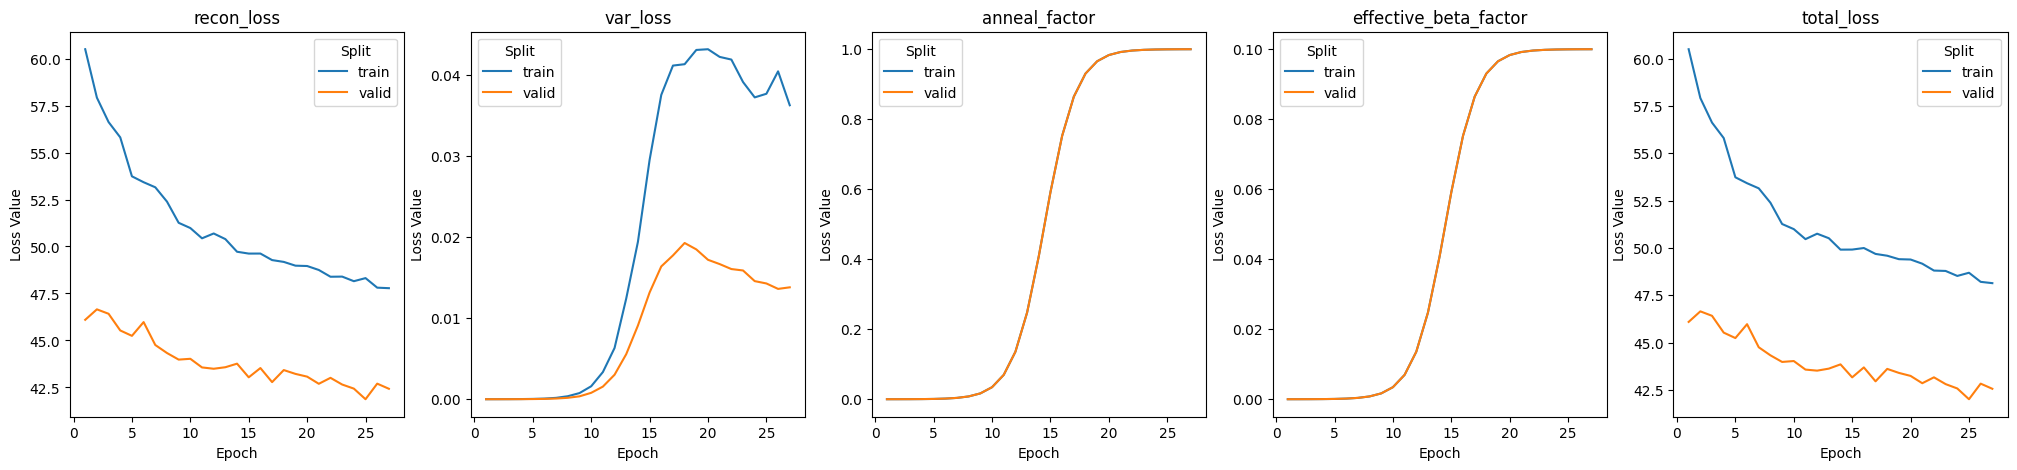

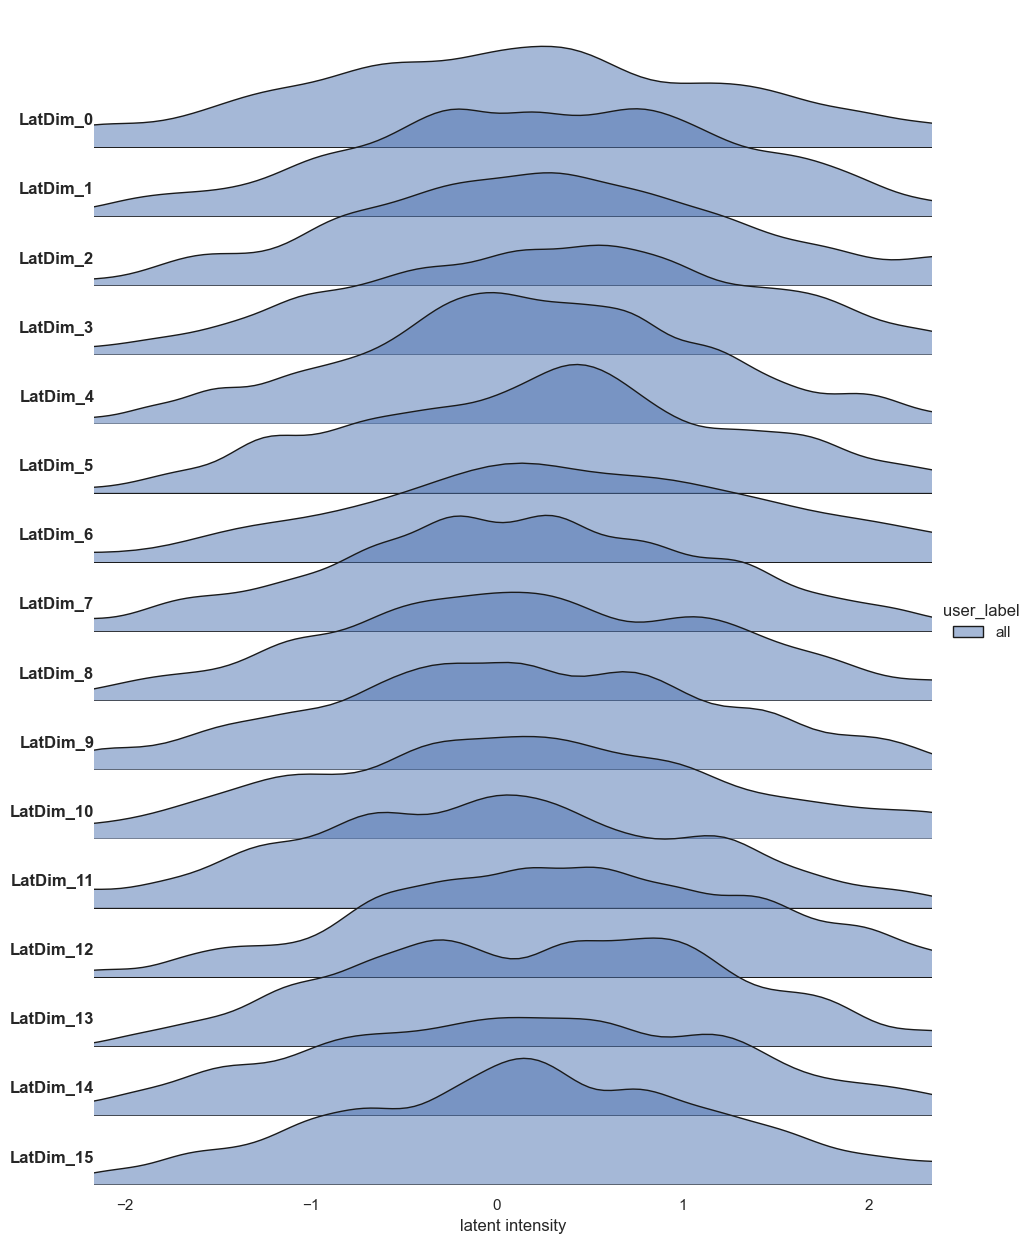

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


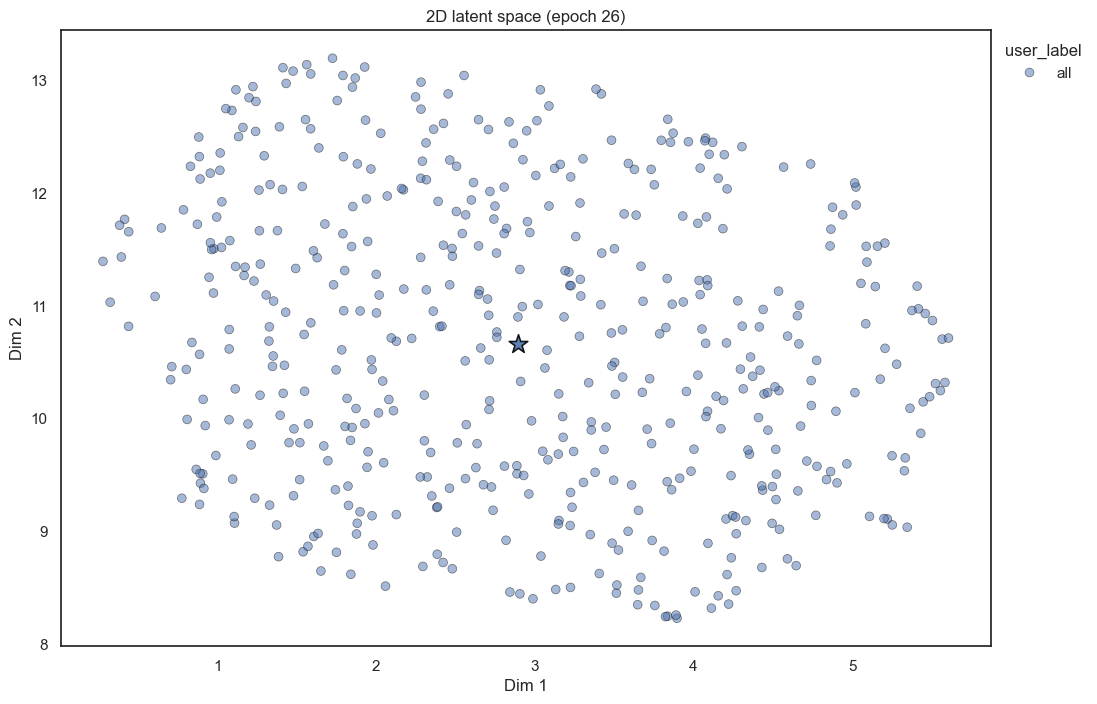

In [6]:
stackix.show_result()

## 5) Customize Stackix Prameters
Since the Stackix is composed of variational autoencoders there are no Stackix specific customizations that where not shown in the `Varix` tutorial.   
However, it is possible to change the architecture to a vanilla autoencoder via the `model_type` attribute when initializing the Stackix.  
Please note, that this attribute is a `Type` and not the instance of the actual class. Therefore you need to import an `Architecture` (see here for https://maxjoas.github.io/autoencodix_package/api/modeling) and the corressponding loss type here `VanillixLoss`, because we're using a vanillia autoencoder architecture see code below for more clearity:

In [7]:
import autoencodix as acx
from autoencodix.configs.default_config import DataCase
from autoencodix.configs.stackix_config import StackixConfig
from autoencodix.utils.example_data import EXAMPLE_MULTI_BULK
from autoencodix.modeling import VanillixArchitecture
from autoencodix.utils import VanillixLoss

my_config = StackixConfig(
    epochs=27,
    checkpoint_interval=5,
    data_case=DataCase.MULTI_BULK,
)
stackix = acx.Stackix(
    data=EXAMPLE_MULTI_BULK,
    config=my_config,
    model_type=VanillixArchitecture,
    loss_type=VanillixLoss,
)
result = stackix.run()

in handle_direct_user_data with data: <class 'autoencodix.data.datapackage.DataPackage'>
anno key: transcriptomics
anno key: proteomics
Training each modality model...
Training modality: transcriptomics
Training modality: transcriptomics
Epoch 1 - Train Loss: 16.3322
Sub-losses: recon_loss: 16.3322
Epoch 1 - Valid Loss: 10.8240
Sub-losses: recon_loss: 10.8240
Epoch 2 - Train Loss: 14.9089
Sub-losses: recon_loss: 14.9089
Epoch 2 - Valid Loss: 10.7479
Sub-losses: recon_loss: 10.7479
Epoch 3 - Train Loss: 13.7051
Sub-losses: recon_loss: 13.7051
Epoch 3 - Valid Loss: 10.7172
Sub-losses: recon_loss: 10.7172
Epoch 4 - Train Loss: 12.8275
Sub-losses: recon_loss: 12.8275
Epoch 4 - Valid Loss: 10.5596
Sub-losses: recon_loss: 10.5596
Epoch 5 - Train Loss: 11.8955
Sub-losses: recon_loss: 11.8955
Epoch 5 - Valid Loss: 10.3606
Sub-losses: recon_loss: 10.3606
Epoch 6 - Train Loss: 11.3932
Sub-losses: recon_loss: 11.3932
Epoch 6 - Valid Loss: 10.0904
Sub-losses: recon_loss: 10.0904
Epoch 7 - Train Lo

## 6) Saving, Loading and Reusing
This works for `Stackix` as for any other models, by using the `save` and `load` methods.

In [8]:
import os
import glob

outpath = os.path.join("tutorial_res", "stackix.pkl")
stackix.save(file_path=outpath)

folder = os.path.dirname(outpath)
pkl_files = glob.glob(os.path.join(folder, "*.pkl"))
model_files = glob.glob(os.path.join(folder, "*.pth"))

print("PKL files:", pkl_files)
print("Model files:", model_files)

# the load functionality automatically will build the pipeline object out of the three saved files
stackix_loaded = acx.Stackix.load("stackix.pkl")

Preprocessor saved successfully.
saving memory efficient
Field(name='model',type=<class 'torch.nn.modules.module.Module'>,default=<dataclasses._MISSING_TYPE object at 0x10b75e2a0>,default_factory=<class 'torch.nn.modules.module.Module'>,init=True,repr=True,hash=None,compare=True,metadata=mappingproxy({}),kw_only=False,_field_type=_FIELD)
Field(name='adata_latent',type=typing.Optional[anndata._core.anndata.AnnData],default=<dataclasses._MISSING_TYPE object at 0x10b75e2a0>,default_factory=<class 'anndata._core.anndata.AnnData'>,init=True,repr=True,hash=None,compare=True,metadata=mappingproxy({}),kw_only=False,_field_type=_FIELD)
Pipeline object saved successfully.
Model state saved successfully.
PKL files: ['tutorial_res/stackix.pkl', 'tutorial_res/stackix.pkl_preprocessor.pkl', 'tutorial_res/van.pkl_preprocessor.pkl', 'tutorial_res/van.pkl']
Model files: ['tutorial_res/stackix.pkl_model.pth', 'tutorial_res/van.pkl_model.pth']
Attempting to load a pipeline from stackix.pkl...
Error: File

In [9]:
from autoencodix.data import MultiModalDataset, NumericDataset, DatasetContainer
from autoencodix.base import BaseDataset
from typing import Literal, Dict, Union
import anndata as ad


def _numeric_ds_to_adata(ds: NumericDataset) -> ad.AnnData:
    return ad.AnnData(
        X=ds.data.detach().cpu().numpy(),
        var=pd.DataFrame(ds.feature_ids),
        obs=ds.metadata,
    )


def _parse_multimodal(mds: MultiModalDataset) -> Dict[str, ad.AnnData]:
    result_dict: Dict[str, ad.AnnData] = {}
    dataset_dict = mds.datasets
    for mod_name, dataset in dataset_dict.items():
        if not isinstance(dataset, NumericDataset):
            raise NotImplementedError(
                f"Feature Importance is only implemented for NumericDataset, got type: {type(dataset)}"
            )
        result_dict[mod_name] = _numeric_ds_to_adata(dataset)
    return result_dict


# main ---------------------
def dataset_to_andata(
    datasetcontainer: DatasetContainer,
    split: Literal["train", "valid", "test"] = "train",
) -> Union[ad.AnnData, Dict[str, ad.AnnData]]:
    if not hasattr(datasetcontainer, split):
        raise ValueError(
            f"Split: {split} not present in DatasetContainer: {datasetcontainer}"
        )
    ds = datasetcontainer[split]
    if isinstance(ds, MultiModalDataset):
        res: Dict[str, ad.AnnData] = _parse_multimodal(mds=ds)
    elif isinstance(datasetcontainer, NumericDataset):
        res: ad.Anndata = _numeric_ds_to_adata(ds=ds)
    else:
        raise NotImplementedError("TODO")
    return res

In [10]:
result.datasets["train"]

In [11]:
ds.datasets.keys()

NameError: name 'ds' is not defined

In [ ]:
datasetcontainer = ds.datasets["proteomics"]

In [ ]:
#
import anndata as ad

my_adata = ad.AnnData(
    X=datasetcontainer.data.detach().cpu().numpy(),
    var=pd.DataFrame(datasetcontainer.feature_ids),
    obs=datasetcontainer.metadata,
)
my_adata

/Users/maximilianjoas/development/autoencodix_package/.venv/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 350 × 10
    obs: 'condition', 'batch', 'quality_score'
    var: 0

In [ ]:
my_adata.var

,0
0,protein_36
1,protein_75
2,protein_13
3,protein_4
4,protein_62
5,protein_30
6,protein_48
7,protein_9
8,protein_69
9,protein_0


In [ ]:
datasetcontainer.metadata

,condition,batch,quality_score
sample_0,condition_0,batch_3,0.883087
sample_1,condition_0,batch_2,0.884084
sample_10,condition_1,batch_2,0.650808
sample_100,condition_2,batch_1,0.714076
sample_101,condition_0,batch_3,0.889173
...,...,...,...
sample_92,condition_2,batch_1,0.747582
sample_93,condition_0,batch_2,0.867771
sample_94,condition_0,batch_3,0.878405
sample_96,condition_1,batch_2,0.919112
